# Explore Yelp Dataset
## Part 1: Data Wrangling using Spark

### By Yayin Cai, April 15th

## 1. Getting Started with Apache Spark

### 1.1 Initializing a Connection to Spark

We'll open a connection to Spark as follows. Note that Spark has multiple interfaces. `SparkSession` is the “most modern” one and we’ll be using it for the analysis.  From `SparkSession`, we can load data into Spark DataFrames as well as `RDD`s.

In [1]:
import numpy as np
import pandas as pd

import time
import networkx as nx
import warnings

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('Graphs').getOrCreate()

### 1.2 Download data

The following code retrieves the Yelp dataset in a zipfile and decompresses it. It will take quite a while.

In [4]:
# Based on https://stackoverflow.com/questions/9419162/download-returned-zip-file-from-url

import zipfile
import urllib.request
import shutil
import os

def get_file(url,file_name):
    urllib.request.urlretrieve(url, file_name)
    
def unzip_file(file_name):
    zip_ref = zipfile.ZipFile(file_name,'r')
    zip_ref.extractall()
    zip_ref.close()

os.mkdir("data")
os.chdir("data")

In [5]:
get_file("http://www.cis.upenn.edu/~cis545/yelp-dataset.zip", "yelp-dataset.zip")

In [6]:
unzip_file("yelp-dataset.zip")

### 1.3 Load Graph Datasets.

For the analysis, we’ll be looking at graph data (reviews, reviewers, businesses) downloaded from Yelp.

**Review of graph theory**

Recall that a graph $G$ is composed of a set of vertices $V$ (also called nodes) and edges $E$ (sometimes called links).  Each vertex $v \in V$ has an identity (often represented in the real world as a string or numeric “node ID”).  Each edge $e \in E$ is a tuple $(v_i,...,v_j)$ where $v_i$ represents the source or origin of the edge, and $v_j$ represents the target or destination.  In the simplest case, the edge tuple above is simply the pair $(v_i,v_j)$ but in many cases we may have additional fields such as a label or a distance.  Recall also that graphs may be undirected or directed; in undirected graphs, all edges are symmetric whereas in directed graphs, they are not.  For instance, airline flights are directed, whereas Facebook friend relationships are undirected. 

**Load Dataset Into Spark**

Now, let's read our social graph datasets from Yelp we just downloaded into Spark.

In [3]:
#Load dataset
yelp_business_attributes_sdf = spark.read.load("yelp_business_attributes.csv", header = True, format = "csv")
yelp_business_hours_sdf = spark.read.load("yelp_business_hours.csv", header = True, format = "csv")
yelp_business_sdf = spark.read.load("yelp_business.csv", header = True, format = "csv")
yelp_check_in_sdf = spark.read.load("yelp_checkin.csv", header = True, format = "csv")
yelp_reviews_sdf = spark.read.load("yelp_review2.csv", header = True, format = "csv")
yelp_users_sdf = spark.read.load("yelp_user.csv", header = True, format = "csv")

In [9]:
yelp_business_hours_sdf.show(5)

+--------------------+---------+---------+---------+---------+---------+---------+---------+
|         business_id|   monday|  tuesday|wednesday| thursday|   friday| saturday|   sunday|
+--------------------+---------+---------+---------+---------+---------+---------+---------+
|FYWN1wneV18bWNgQj...|7:30-17:0|7:30-17:0|7:30-17:0|7:30-17:0|7:30-17:0|     None|     None|
|He-G7vWjzVUysIKrf...| 9:0-20:0| 9:0-20:0| 9:0-20:0| 9:0-20:0| 9:0-16:0| 8:0-16:0|     None|
|KQPW8lFf1y5BT2Mxi...|     None|     None|     None|     None|     None|     None|     None|
|8DShNS-LuFqpEWIp0...|10:0-21:0|10:0-21:0|10:0-21:0|10:0-21:0|10:0-21:0|10:0-21:0|11:0-19:0|
|PfOCPjBrlQAnz__NX...| 11:0-1:0| 11:0-1:0| 11:0-1:0| 11:0-1:0| 11:0-1:0| 11:0-2:0| 11:0-0:0|
+--------------------+---------+---------+---------+---------+---------+---------+---------+
only showing top 5 rows



In [10]:
yelp_check_in_sdf.show(5)

+--------------------+-------+-----+--------+
|         business_id|weekday| hour|checkins|
+--------------------+-------+-----+--------+
|3Mc-LxcqeguOXOVT_...|    Tue| 0:00|      12|
|SVFx6_epO22bZTZnK...|    Wed| 0:00|       4|
|vW9aLivd4-IorAfSt...|    Tue|14:00|       1|
|tEzxhauTQddACyqdJ...|    Fri|19:00|       1|
|CEyZU32P-vtMhgqRC...|    Tue|17:00|       1|
+--------------------+-------+-----+--------+
only showing top 5 rows



In [11]:
yelp_business_sdf.show(5)

+--------------------+--------------------+------------+--------------------+--------------+-----+-----------+----------+------------+-----+------------+-------+--------------------+
|         business_id|                name|neighborhood|             address|          city|state|postal_code|  latitude|   longitude|stars|review_count|is_open|          categories|
+--------------------+--------------------+------------+--------------------+--------------+-----+-----------+----------+------------+-----+------------+-------+--------------------+
|FYWN1wneV18bWNgQj...|    Dental by Design|        null|4855 E Warner Rd,...|     Ahwatukee|   AZ|      85044|33.3306902|-111.9785992|  4.0|          22|      1|Dentists;General ...|
|He-G7vWjzVUysIKrf...| Stephen Szabo Salon|        null|  3101 Washington Rd|      McMurray|   PA|      15317|40.2916853| -80.1048999|  3.0|          11|      1|Hair Stylists;Hai...|
|KQPW8lFf1y5BT2Mxi...|Western Motor Veh...|        null|6025 N 27th Ave, ...|       P

In [12]:
yelp_reviews_sdf.show(5)

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|     0|    0|   0|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|     0|    0|   0|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|2016-05-28|Lester's is locat...|     0|    0|   0|
|IXvOzsEMYtiJI0CAR...|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|    4|2016-05-28|Love coming here....|     0|    0|   0|
|L_9BTb55X0GDtThi6...|bv2nCi5Qv5vroFiqK...|s2I_Ni76bjJNK9yG6...|    4|2016-05-28|Had their chocola...|     0|    0|   0|
+--------------------+----------

In [13]:
yelp_business_sdf.dtypes

[('business_id', 'string'),
 ('name', 'string'),
 ('neighborhood', 'string'),
 ('address', 'string'),
 ('city', 'string'),
 ('state', 'string'),
 ('postal_code', 'string'),
 ('latitude', 'string'),
 ('longitude', 'string'),
 ('stars', 'string'),
 ('review_count', 'string'),
 ('is_open', 'string'),
 ('categories', 'string')]

In [14]:
yelp_reviews_sdf.dtypes

[('review_id', 'string'),
 ('user_id', 'string'),
 ('business_id', 'string'),
 ('stars', 'string'),
 ('date', 'string'),
 ('text', 'string'),
 ('useful', 'string'),
 ('funny', 'string'),
 ('cool', 'string')]

In [15]:
yelp_users_sdf.dtypes

[('user_id', 'string'),
 ('name', 'string'),
 ('review_count', 'string'),
 ('yelping_since', 'string'),
 ('friends', 'string'),
 ('useful', 'string'),
 ('funny', 'string'),
 ('cool', 'string'),
 ('fans', 'string'),
 ('elite', 'string'),
 ('average_stars', 'string'),
 ('compliment_hot', 'string'),
 ('compliment_more', 'string'),
 ('compliment_profile', 'string'),
 ('compliment_cute', 'string'),
 ('compliment_list', 'string'),
 ('compliment_note', 'string'),
 ('compliment_plain', 'string'),
 ('compliment_cool', 'string'),
 ('compliment_funny', 'string'),
 ('compliment_writer', 'string'),
 ('compliment_photos', 'string')]

In [16]:
yelp_business_attributes_sdf.dtypes

[('business_id', 'string'),
 ('AcceptsInsurance', 'string'),
 ('ByAppointmentOnly', 'string'),
 ('BusinessAcceptsCreditCards', 'string'),
 ('BusinessParking_garage', 'string'),
 ('BusinessParking_street', 'string'),
 ('BusinessParking_validated', 'string'),
 ('BusinessParking_lot', 'string'),
 ('BusinessParking_valet', 'string'),
 ('HairSpecializesIn_coloring', 'string'),
 ('HairSpecializesIn_africanamerican', 'string'),
 ('HairSpecializesIn_curly', 'string'),
 ('HairSpecializesIn_perms', 'string'),
 ('HairSpecializesIn_kids', 'string'),
 ('HairSpecializesIn_extensions', 'string'),
 ('HairSpecializesIn_asian', 'string'),
 ('HairSpecializesIn_straightperms', 'string'),
 ('RestaurantsPriceRange2', 'string'),
 ('GoodForKids', 'string'),
 ('WheelchairAccessible', 'string'),
 ('BikeParking', 'string'),
 ('Alcohol', 'string'),
 ('HasTV', 'string'),
 ('NoiseLevel', 'string'),
 ('RestaurantsAttire', 'string'),
 ('Music_dj', 'string'),
 ('Music_background_music', 'string'),
 ('Music_no_music', 

In [17]:
yelp_reviews_sdf.dtypes

[('review_id', 'string'),
 ('user_id', 'string'),
 ('business_id', 'string'),
 ('stars', 'string'),
 ('date', 'string'),
 ('text', 'string'),
 ('useful', 'string'),
 ('funny', 'string'),
 ('cool', 'string')]

### 1.4 Simple Wrangling in Spark DataFrames

Currently, some of the data from the Yelp dataset is a bit ugly.

In this section we will need to:
* Create SQL tables for each Spark DataFrames we created in the previous step.
* Clean `yelp_business_hours` by replacing `"None"` with a Spark `null`.
* Clean `yelp_users` by replacing `"None"` with a Spark `null`.

### 1.4.1 Spark DataFrames SQL Tables

In [18]:
yelp_business_attributes_sdf.createOrReplaceTempView("yelp_business_attributes")
yelp_business_hours_sdf.createOrReplaceTempView("yelp_business_hours")
yelp_business_sdf.createOrReplaceTempView("yelp_business")
yelp_check_in_sdf.createOrReplaceTempView("yelp_check_in")
yelp_reviews_sdf.createOrReplaceTempView("yelp_reviews")
yelp_users_sdf.createOrReplaceTempView("yelp_users")

### 1.4.2 Cleaning None's
To now convert the string `"None"` to Spark `null`, we'll need to define a function `replace_none_with_null` to apply to then apply to our DataFrames.

In [19]:
def replace_none_with_null(x):
    # This function should take a string parameter and compare it with 
    # 'None' and 'Na'. If there is a match to either, it should return
    # the Python None value otherwise it should return the passed value.
    if (x == 'None') or (x == 'Na'):
        return None
    else:
        return x

In [20]:
if replace_none_with_null('None'):
    raise ValueError('The function does not work')

In [21]:
# The following code wraps the Python code in a Spark UDF 

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, NullType

spark.udf.register('replace_none_with_null', replace_none_with_null,StringType())
spark_replace_none_with_null = udf(replace_none_with_null, StringType())

Now we can use the above created UDF in SQL to replace the 'None's and 'Na's from `yelp_business_hours_sdf` and `yelp_users`.

In [22]:
for col in yelp_business_hours_sdf.schema.names:
    yelp_business_hours_sdf = yelp_business_hours_sdf.withColumn(col, spark_replace_none_with_null(yelp_business_hours_sdf[col]))
    
for col in yelp_users_sdf.schema.names:
    yelp_users_sdf = yelp_users_sdf.withColumn(col, spark_replace_none_with_null(yelp_users_sdf[col]))

In [23]:
yelp_business_hours_sdf.show(10)

+--------------------+---------+---------+---------+---------+---------+---------+---------+
|         business_id|   monday|  tuesday|wednesday| thursday|   friday| saturday|   sunday|
+--------------------+---------+---------+---------+---------+---------+---------+---------+
|FYWN1wneV18bWNgQj...|7:30-17:0|7:30-17:0|7:30-17:0|7:30-17:0|7:30-17:0|     null|     null|
|He-G7vWjzVUysIKrf...| 9:0-20:0| 9:0-20:0| 9:0-20:0| 9:0-20:0| 9:0-16:0| 8:0-16:0|     null|
|KQPW8lFf1y5BT2Mxi...|     null|     null|     null|     null|     null|     null|     null|
|8DShNS-LuFqpEWIp0...|10:0-21:0|10:0-21:0|10:0-21:0|10:0-21:0|10:0-21:0|10:0-21:0|11:0-19:0|
|PfOCPjBrlQAnz__NX...| 11:0-1:0| 11:0-1:0| 11:0-1:0| 11:0-1:0| 11:0-1:0| 11:0-2:0| 11:0-0:0|
|o9eMRCWt5PkpLDE0g...| 18:0-0:0| 18:0-0:0| 18:0-0:0| 18:0-0:0| 18:0-0:0| 18:0-0:0|     null|
|kCoE3jvEtg6UVz5SO...| 8:0-17:0| 8:0-17:0| 8:0-17:0| 8:0-17:0| 8:0-17:0|     null|     null|
|OD2hnuuTJI9uotcKy...|11:0-19:0|11:0-19:0|11:0-19:0|11:0-19:0|11:0-19:

In [24]:
yelp_users_sdf.show(10)

+--------------------+-------+------------+-------------+--------------------+------+-----+----+----+-----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+
|             user_id|   name|review_count|yelping_since|             friends|useful|funny|cool|fans|elite|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|
+--------------------+-------+------------+-------------+--------------------+------+-----+----+----+-----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+
|JJ-aSuM4pCFPdkfoZ...|  Chris|          10|   2013-09-24|0njfJmB-7n84DlIgU...|    

### 1.5 Simple Analytics on the Data

In this section, we will be executing Spark operations on the data given. 

#### 1.5.1 Most reviewed business in PA 

First, we would like to see "most reviewed business" in Pennsylvania. This should be a table of businesses that: <br>
(1) are in the `state` of Pennsylvania (PA) <br>
(2) with a rating (`stars`) greater than or equal to 4.0  <br>
(3) finally, we want to sort this by the number of reviews (`review_count`) in descending order, and if they have the same `review_count` then sort alphabetically by their names in ascending order.

In [25]:
PA_most_reviewed_sdf = spark.sql("select name, stars, review_count from yelp_business \
                                  where state = 'PA' and stars >= 4 \
                                  order by review_count desc, name")

In [26]:
PA_most_reviewed_sdf.show(10)

+--------------------+-----+------------+
|                name|stars|review_count|
+--------------------+-----+------------+
|Tootie's Famous I...|  4.0|          99|
|Vincent's Pizza Park|  4.0|          99|
|      Brew Gentlemen|  4.5|          98|
|              Lot 17|  4.0|          98|
|             Peppi's|  4.5|          98|
|       Totin's Diner|  4.0|          98|
| East End Food Co-Op|  4.5|          97|
|       Hidden Harbor|  4.5|          97|
|   Kavsar Restaurant|  4.5|          97|
|     Pizza Perfectta|  4.0|          97|
+--------------------+-----+------------+
only showing top 10 rows



#### 1.5.2 Businesses with the highest average review

Next, we want to see the businesses with the highest average review. This should be a table of business names <br>
(1) sorted by the average review score (in descending order) and if they have the same score they should then be sorted alphabetically by their name (ascending order)

In [27]:
best_businesses_sdf = spark.sql("select name, avg(cast(r.stars as int)) as avg_rating\
                                 from yelp_business b join yelp_reviews r\
                                 on b.business_id = r.business_id\
                                 group by b.name order by avg_rating desc, name")

In [28]:
best_businesses_sdf.show(10)

+--------------------+----------+
|                name|avg_rating|
+--------------------+----------+
|"""T""s Hair Affair"|       5.0|
|"Davis ""N"" Sons...|       5.0|
|"Manantial De Sal...|       5.0|
| "Scotty""s Kitchen"|       5.0|
|"Wallbeds ""n"" M...|       5.0|
|   $40 Backflow Test|       5.0|
|  'Round Table Tours|       5.0|
|         1 One Armor|       5.0|
|              1 Reef|       5.0|
|1 STOP Banner pri...|       5.0|
+--------------------+----------+
only showing top 10 rows



#### 1.5.3 Difference from average in PA
Next, we will work with `yelp_business_sdf` for businesses in PA.

We can use `yelp_business_sdf` to create a new SDF named `new_yelp_business_sdf`. This should be a table of businesses <br>
(1) that are in the state of PA <br>
(2) containing the columns `business_id`, `name` and `stars` <br>
(3) as well as a new column called `avg_stars_diff`.  This column should contain the difference between the business's `stars` and the average `stars` rating across
all businesses in _PA_.

In [29]:
new_yelp_business_sdf = spark.sql("select business_id, name, stars, \
                                  (cast(stars as int)-(select avg(cast(stars as int)) from yelp_business where state = 'PA')) as avg_stars_diff\
                                    from yelp_business where state = 'PA'")

In [30]:
new_yelp_business_sdf.show(10)

+--------------------+--------------------+-----+-------------------+
|         business_id|                name|stars|     avg_stars_diff|
+--------------------+--------------------+-----+-------------------+
|He-G7vWjzVUysIKrf...| Stephen Szabo Salon|  3.0|-0.3718468691265211|
|EsMcGiZaQuG1OOvL9...|    Any Given Sundae|  5.0|  1.628153130873479|
|XOSRcvtaKc_Q5H1SA...|   East Coast Coffee|  4.5| 0.6281531308734789|
|NmZtoE3v8RdSJEczY...|Complete Dental Care|  2.0| -1.371846869126521|
|BnuzcebyB1AfxH0kj...|Carrabba's Italia...|  3.5|-0.3718468691265211|
|FmGZh8ZwEnSO860_2...|Enterprise Rent-A...|  3.0|-0.3718468691265211|
|EJFdWX908N8Yc2XG0...|     River Moon Cafe|  4.0| 0.6281531308734789|
|o1fTwfqN0sDFNpV1C...|  Crazy Mocha Coffee|  3.5|-0.3718468691265211|
|-nHkhiuerqmfBG3v2...|   Bruegger's Bagels|  2.5| -1.371846869126521|
|HcEJ2YiSLX_mT3RE0...|               Blush|  3.0|-0.3718468691265211|
+--------------------+--------------------+-----+-------------------+
only showing top 10 

#### 1.5.4 Most common check-in days/times times in PA

We will now find the weekday/hour pairs with the most checkins for all businesses in PA, sorted in descending order of checkins.  

This should be a table of businesses with <br>
(1) columns `weekday`, `hour` and <br>
(2) a new column called `num_checkins` containing the total number of checkins that occurred on the given weekday/hour pair in **any business in PA**. Make sure that the `hour` column contains only the hour number, i.e. 8:00 --> 8  

In [31]:
common_PA_checkin_sdf = spark.sql("select weekday, split(hour,':')[0] as hour, sum(checkins) as num_checkins \
                                    from yelp_check_in c join yelp_business b on c.business_id = b.business_id\
                                    where b.state = 'PA' group by weekday, hour")

In [32]:
common_PA_checkin_sdf.show(10)

+-------+----+------------+
|weekday|hour|num_checkins|
+-------+----+------------+
|    Wed|  22|      7712.0|
|    Mon|   2|      1466.0|
|    Wed|   8|       205.0|
|    Sun|  23|      5853.0|
|    Sat|  16|      9604.0|
|    Tue|  19|      3173.0|
|    Sat|   2|      4285.0|
|    Thu|  15|      3918.0|
|    Mon|  15|      3630.0|
|    Tue|  11|      1572.0|
+-------+----+------------+
only showing top 10 rows



## 2. Simple Graph Algorithms

### 2.1 Generate user-business graph

For this step, we will construct a *directed* graph with edges from users to businesses indicating reviews. To do this, we have to extract from `yelp_reviews_sdf` the `user_id` as the `from_node`, the `business_id` as the `to_node`, and the `stars` field as the `score`. 

In [33]:
review_graph_sdf = spark.sql("select user_id as from_node, business_id as to_node, stars as score from yelp_reviews\
                              where user_id is not null and business_id is not null")

In [34]:
review_graph_sdf.show(10)

+--------------------+--------------------+-----+
|           from_node|             to_node|score|
+--------------------+--------------------+-----+
|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|
|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|
|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|
|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|    4|
|bv2nCi5Qv5vroFiqK...|s2I_Ni76bjJNK9yG6...|    4|
|_4iMDXbXZ1p1ONG29...|8QWPlVQ6D-OExqXoa...|    5|
|u0LXt3Uea_GidxRW1...|9_CGhHMz8698M9-Pk...|    4|
|u0LXt3Uea_GidxRW1...|gkCorLgPyQLsptTHa...|    4|
|u0LXt3Uea_GidxRW1...|5r6-G9C4YLbC7Ziz5...|    3|
|u0LXt3Uea_GidxRW1...|fDF_o2JPU8BR1Gya-...|    5|
+--------------------+--------------------+-----+
only showing top 10 rows



### 2.2 Distributed Breadth-First Search
A search algorithm typically starts at a node or set of nodes, and “explores” or “walks” for some number of steps to find a match or a set of matches.

Let’s implement a distributed version of a popular algorithm, breadth-first-search (BFS).  This algorithm is given a graph `G`, a set of origin nodes `N`, and a depth `d`.  In each iteration or round up to depth `d`, it explores the set of all new nodes directly connected to the nodes it already has seen, before going on to the nodes another “hop” away.  If we do this correctly, we will explore the graph in a way that (1) avoids getting caught in cycles or loops, and (2) visits each node in the fewest number of “hops” from the origin.  BFS is commonly used in tasks such as friend recommendation in social networks.

![ChessUrl](https://upload.wikimedia.org/wikipedia/commons/5/5d/Breadth-First-Search-Algorithm.gif "BFS")

**How does distributed BFS in Spark work**?  Let’s start with a brief sketch of standard BFS.  During exploration “rounds”, we can divide the graph into three categories:

1. *unexplored nodes*.  These are nodes we have not yet visited.  We don’t necessarily need to track these separately from the graph.
2. *visited nodes*.  We have already reached these nodes in a previous “round”.
3. *frontier nodes*.  These are nodes we have visited in this round.  We have not yet checked whether they have out-edges connecting to unexplored nodes.

We can illustrate these with a figure and an example.


![Graph traversal](https://drive.google.com/uc?export=view&id=1I2Kc3uQcDlp7RsDqRQAfQAvS3F_VcJpA)

Let’s look at the figure, which shows a digraph.  The green node A represents the origin.

* In the first round, the origin A is the sole frontier node.  We find all nodes reachable directly from A, namely B-F; then we remove all nodes we have already visited (there are none) or that are in the frontier (the node A itself).  This leaves the blue nodes B-F, which are all reachable in (at most) 1 hop from A.
* In the second round, we move A to the visited set and B-F to the frontier.  Now we explore all nodes connected directly to frontier nodes, namely A (from B), F (from E), and the red nodes G-L.  We eliminate the nodes already contained in the frontier and visited sets from the next round’s frontier set, leaving the red nodes only.
* In the third round, we will move B-F to the visited set, G-L to the frontier set, and explore the next round of neighbors N-V.  This process continues up to some maximum depth (or until there are no more unexplored nodes).

Assume we create data structures (we can make them DataFrames) for the visited and frontier nodes.  Consider (1) how to initialize the different sets at the start of computation (note: unexplored nodes are already in the graph), and (2) how to use the graph edges and the existing data structures to update state for the next iteration “round”.

#### 2.2.1 Breadth-First Search Algorithm

Now, we want to create a function `spark_bfs(G, origins, max_depth)` that takes a Spark DataFrame with a graph G (following the schema for `review_graph_sdf` described above, but to be treated as an **undirected graph**) and a nonnegative integer “exploration depth” `max_depth` (to only run BFS on a tractable portion of the graph).  The `max_depth` will be the maximum number of edge traversals (e.g., the origin is at `max_depth=0`, one hop from the origin is `max_depth=1`, etc.  The function should return a DataFrame containing pairs of the form (node, distance), where the distance is depth at which $n$ was *first* encountered (i.e., the shortest-path distance from the origin nodes). 


In [35]:
from pyspark.sql.functions import lit

def spark_bfs(G, origins, max_depth):
    schema = StructType([
            StructField("node", StringType(), True)
        ])

    current_sdf = spark.createDataFrame(origins, schema)
    current_sdf = current_sdf.withColumn("depth", lit(0))
    
    frontier_sdf = spark.createDataFrame(origins, schema)
    frontier_sdf = frontier_sdf.withColumn("depth", lit(0))
    
    visited_sdf = spark.createDataFrame(origins, schema)
    visited_sdf = visited_sdf.withColumn("depth", lit(0))
    
    depth = 0
    
    G.createOrReplaceTempView("graph")
    
    while depth < max_depth:
        #update frontier_sdf
        current_sdf.createOrReplaceTempView("current")
        
        frontier_sdf = spark.sql("select graph.to_node as node from current left join graph \
                                    on current.node = graph.from_node union select \
                                    graph.from_node as node from current left join graph \
                                    on current.node = graph.to_node")
        
        #update current_sdf
        current_sdf = frontier_sdf
        current_sdf = current_sdf.withColumn("depth", lit(depth+1))
        
        #update visited_sdf
        visited_sdf = visited_sdf.union(current_sdf)
        
        
        
        depth = depth + 1

    visited_sdf.createOrReplaceTempView("visited")
    
    final_sdf = spark.sql("select node, min(depth) as depth from visited where node is not null group by node ")
    
    return final_sdf

In [36]:
#Test before applying to a larger dataset
import pandas as pd

data = {'from_node': ['A', 'A', 'A', 'C', 'B', 'G', 'D'],
       'to_node': ['B', 'C', 'D', 'F', 'G', 'H', 'E']}
uh = pd.DataFrame.from_dict(data)
uh_sdf = spark.createDataFrame(uh)
smallOrig = [{'node': 'C'}]

smallTest = spark_bfs(uh_sdf, smallOrig, 2)

smallTest.show()

+----+-----+
|node|depth|
+----+-----+
|   F|    1|
|   B|    2|
|   D|    2|
|   C|    0|
|   A|    1|
+----+-----+



The result aligns with the expectation.

#### 2.2.2 Restaurant Recommendation

Now we can create a function `friend_rec` that takes in two arguments: the graph_sdf and the ID of a user, `user`.  Using the `spark_bfs()` as a help function it should return restaurants with a rating greater than 4.0 that were reviewed by users who reviewed similar restaurants as `user` reviewed.  To do this, first find all users who have reviewed some restaurant that `user` reviewed, and then find all restaurants that they reviewed (excluding the ones `user` already reviewed) with a rating greater or equal to 4.0. 

In [37]:
review_graph_sdf.createOrReplaceTempView('reviewtemp')
sample = spark.sql("select * from reviewtemp limit 20")
sample.show(5, False)

+----------------------+----------------------+-----+
|from_node             |to_node               |score|
+----------------------+----------------------+-----+
|bv2nCi5Qv5vroFiqKGopiw|AEx2SYEUJmTxVVB18LlCwA|5    |
|bv2nCi5Qv5vroFiqKGopiw|VR6GpWIda3SfvPC-lg9H3w|5    |
|bv2nCi5Qv5vroFiqKGopiw|CKC0-MOWMqoeWf6s-szl8g|5    |
|bv2nCi5Qv5vroFiqKGopiw|ACFtxLv8pGrrxMm6EgjreA|4    |
|bv2nCi5Qv5vroFiqKGopiw|s2I_Ni76bjJNK9yG60iD-Q|4    |
+----------------------+----------------------+-----+
only showing top 5 rows



In [38]:
def friend_rec(review_graph_sdf, user):
    orig  = [{'node': user}] 
    review_graph_sdf.createOrReplaceTempView('review_graph')
    
    
    review_graph_agg_sdf = spark.sql("select to_node, avg(score) as score, count(*) as count from review_graph\
                                      group by to_node having score>=4")
    
    review_graph_agg_sdf.createOrReplaceTempView('review_graph_agg')
    all_restaurants_sdf = spark_bfs(review_graph_sdf, orig, 3) 
    
    all_restaurants_sdf.createOrReplaceTempView('all_restaurants')
    rec_restaurants_sdf = spark.sql("select node, score, count from (select node from all_restaurants\
                                    where depth=3) all_restaurants\
                                    left join review_graph_agg on \
                                    all_restaurants.node = review_graph_agg.to_node\
                                    order by count desc")
    
    return rec_restaurants_sdf

In [39]:
recommended_sdf = friend_rec(review_graph_sdf, 'bv2nCi5Qv5vroFiqKGopiw')
recommended_sdf.show(10)

+--------------------+------------------+-----+
|                node|             score|count|
+--------------------+------------------+-----+
|4JNXUYY8wbaaDmk3B...| 4.120483564248845| 7362|
|DkYS3arLOhA8si5uU...| 4.268993839835729| 4870|
|KskYqH1Bi7Z_61pH6...| 4.227994955863808| 3965|
|iCQpiavjjPzJ5_3gP...| 4.133654103180968| 3741|
|XZbuPXdyA0ZtTu3Az...| 4.002656924609764| 3011|
|RwMLuOkImBIqqYj4S...| 4.206375153248876| 2447|
|t-o_Sraneime4DDhW...| 4.023360655737705| 2440|
|faPVqws-x-5k2CQKD...| 4.413807708598052| 2361|
|fL-b760btOaGa85OJ...|4.3887931034482754| 2320|
|UPIYuRaZvknINOd1w...| 4.156331877729258| 2290|
+--------------------+------------------+-----+
only showing top 10 rows



#### 2.2.3 Shortest Path

Now we can create a function `shortest_path(from_user, to_user)` that takes in two arguemnts: `from_user` being the `user_id` of the start node and `to_user` being the `user_id` of the end node. The function could modify `spark_bfs` to find the smallest number of restaurants between the two users.

In [40]:
def shortest_path(from_user, to_user, review_graph_sdf):
    schema = StructType([
            StructField("node", StringType(), True)
        ])
    
    origins  = [{'node': from_user}] 

    current_sdf = spark.createDataFrame(origins, schema)
    current_sdf = current_sdf.withColumn("depth", lit(0))
    
    frontier_sdf = spark.createDataFrame(origins, schema)
    frontier_sdf = frontier_sdf.withColumn("depth", lit(0))
    
    visited_sdf = spark.createDataFrame(origins, schema)
    visited_sdf = visited_sdf.withColumn("depth", lit(0))
    
    depth = 0
    search = True
    
    review_graph_sdf.createOrReplaceTempView("graph")
    
    while search:
        #update frontier_sdf
        current_sdf.createOrReplaceTempView("current")
        
        frontier_sdf = spark.sql("select graph.to_node as node from current left join graph \
                                    on current.node = graph.from_node union select \
                                    graph.from_node as node from current left join graph \
                                    on current.node = graph.to_node")
        
        #update current_sdf
        current_sdf = frontier_sdf
        current_sdf = current_sdf.withColumn("depth", lit(depth+1))
        
        
        if current_sdf.filter(current_sdf.node == to_user).count()>0:
            search = False
            
        depth = depth + 1
    
    return depth/2

In [41]:
distance = shortest_path('bv2nCi5Qv5vroFiqKGopiw','-bgszoDnhaUEuVydd4CRPw',review_graph_sdf)

In [42]:
distance

1.0

## 3. Friend Visualization


### 3.1 Loading data subsets
A closer look at the `yelp_user` dataframe tells us that there is an attribute called `friends` that we can use in order to construct an undirected friend graph.  For this part of the assignment we'll go back to Pandas -- not Spark -- DataFrames.

We will work with the a small portion of the `yelp_user` data file and visualize these users' friends. We only want to focus on the users who have at least one friend.

First, let's see how many users in the dataset.

In [11]:
yelp_users_sdf.count()

1326100

We want to focus on the users who have at least one friend.

In [12]:
yelp_users_friends_sdf = yelp_users_sdf.filter(F.col("friends") != "None")

Check how many users have at least one friend.

In [13]:
yelp_users_friends_sdf.count()

760007

In [81]:
user_1000 = yelp_users_friends_sdf.limit(1000).toPandas()  

In [82]:
user_1000.head()

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,"0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gpg...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
1,h5ERTYn2vQ1QbjTZvfWPaA,Bobby,3,2017-01-07,"jYiZnueCr7gVq9T34xoa7g, yFLXGdY6rpHt7hRiwEFMag...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
2,jYnkJR3T8yCERXywoVhWYA,Hugo,48,2010-07-06,"hkXekeW_Jj6mIy8r8N7r1Q, dQDpV-VUtwYGqHznuRV-yw...",15,6,2,3,None,...,0,0,0,0,1,1,1,1,2,0
3,fV8Yr0c5tFQTQ2SRRJHXHw,Michelle,50,2007-08-22,"HDb4fBWIAQ-foS8qLJty9w, x0hBZsmBTYxhjjx0MShz1A...",43,12,5,1,2009,...,4,0,0,0,9,7,7,7,4,0
4,aw973Pm1nrTbRjP4zY9B9g,Kenny,762,2008-09-23,"Cit5yho-DqotA0BnXHErTQ, bm2DqfP4P454FjEtCbZdkQ...",174,151,67,27,"2014, 2016, 2013, 2015, 2010, 2012, 2011",...,4,2,7,0,16,52,47,47,14,1


###  3.2 Extracting friend as list
The `friends` column is a string with comma-separated `user_id`s as values. We will make use of `lambda` functions to extract the different `user_id`s from this comma separated string, and apply this function to each row.

In [83]:
user_1000['list_friends'] = user_1000["friends"].apply(lambda x: x.split(",") if x!=None else [])

In [84]:
user_1000[['name','list_friends']].head()

,name,list_friends
0,Chris,"[0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19G..."
1,Bobby,"[jYiZnueCr7gVq9T34xoa7g, yFLXGdY6rpHt7hRiwEFM..."
2,Hugo,"[hkXekeW_Jj6mIy8r8N7r1Q, dQDpV-VUtwYGqHznuRV-..."
3,Michelle,"[HDb4fBWIAQ-foS8qLJty9w, x0hBZsmBTYxhjjx0MShz..."
4,Kenny,"[Cit5yho-DqotA0BnXHErTQ, bm2DqfP4P454FjEtCbZd..."


### 3.3 Obtaining Friend lists

We now want to create a dataframe called `subset_users` of edges constructed from 
the `user_id` and `list_friends` columns. 

In [85]:
# projection to users and lists of friends, stacked
friend_data = user_1000.set_index(['name'])['list_friends'].apply(pd.Series).stack()
friend_data = friend_data.reset_index()
friend_data.columns = ["source","level_1","target"]

In [86]:
friend_data.head()

,source,level_1,target
0,Chris,0,0njfJmB-7n84DlIgUByCNw
1,Chris,1,rFn3Xe3RqHxRSxWOU19Gpg
2,Chris,2,HVUAmApa0fCbHHVJ0ALshw
3,Chris,3,LBOTb6bJjCdFyDLNswUGmA
4,Chris,4,cy3d0moQOsrhWo6VAyA_kA


Check how many rows are in the dataframe.

In [87]:
len(friend_data)

142430

We want to visualize the friends with more connections. Let's move to target side.

In [88]:
target_count = friend_data.groupby("target").count()
target_count = target_count.reset_index()
target_count = target_count[["target","source"]]
target_count.columns = ["target","count"]

In [90]:
target_count.sort_values("count", ascending = False).head()

,target,count
20333,9BoPpMPWLG0xPQ1w6SDwPQ,15
19511,8lEywHSvti2UjFP8ODbnHg,15
29614,Dkb-TJFNSWl4PYR8wEcWcw,15
23817,AxfLs-3fwGyBM0KJd7ttdA,14
93012,iLjMdZi0Tm7DQxX1C1_2dg,14


Select the users who's friends have no fewer than 10 friends. 

In [96]:
target_count = target_count[target_count["count"]>=10]

In [97]:
friend_data = pd.merge(friend_data, target_count, how = "inner", on = "target")

Check how many rows are in the dataframe now.

In [93]:
len(friend_data)

825

### 3.4 Visualization using Networkx

In this step we will use the `networkx` library to visualize.

In [94]:
# networkx graph ready to draw
import matplotlib.pyplot as plt
import networkx as nx
graph = nx.from_pandas_edgelist(friend_data, "source", "target")

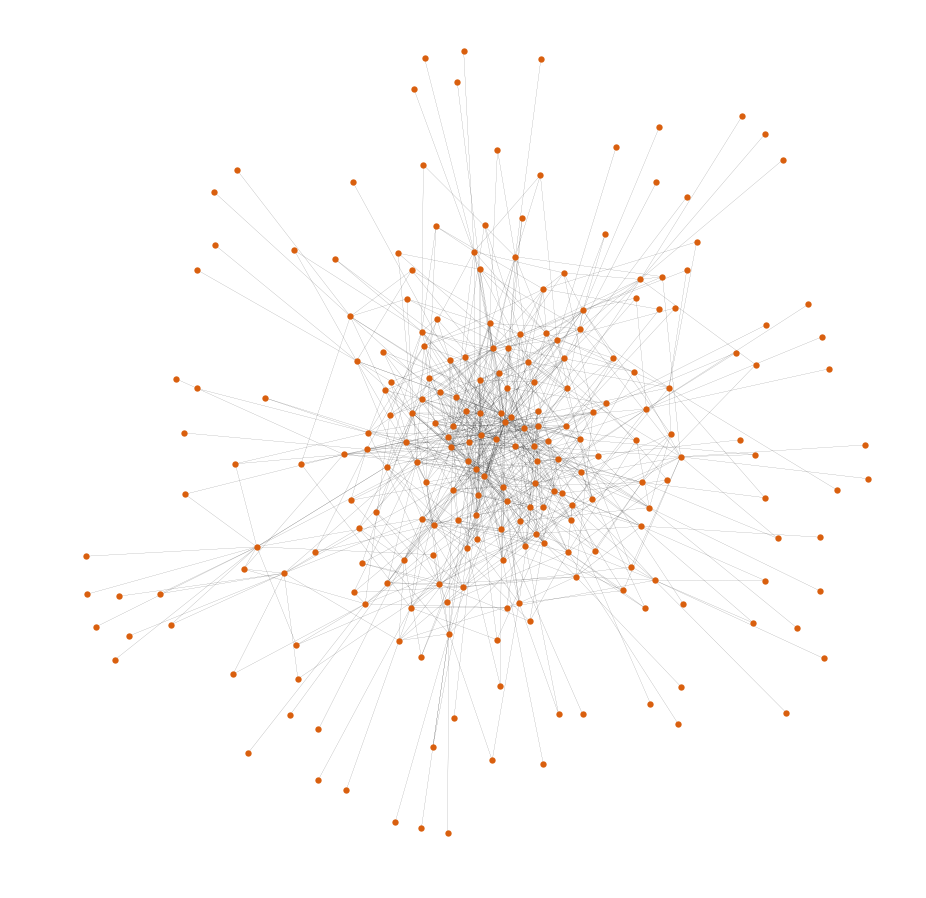

In [101]:
plt.figure(figsize=(12,12))
nx.draw(graph,node_color = "#d95f0e", node_size = 40, line_color = 'grey', linewidths = 0, width = 0.1)
plt.show()

Note: the analysis is based on the **CIS 545 Big Data Analytics** - assignment 2 at University of Pennsylvania. The paragraphs are shamelessly stolen from the assignment notes.